# Simple Example

In [16]:
import sys

sys.path.append('~/wayy-research/wrtrade/')

In [20]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import wrtrade as wrt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
index = pd.date_range(start='2022-01-01', end='2022-01-30')
data = np.random.normal(100, 10, size=30)
signal = np.random.choice([-1,0,1], size=30)
market_data = pd.Series(index=index, data=[150.0, 160.0, 170.0, 180.0, 190.0, 200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0, 400.0, 410.0, 420.0, 430.0, 440.0])
signals = pd.Series(index=index, data=signal)


p = wrt.Portfolio(market_data, signals) 
p.calculate_portfolio_returns()

INFO:wrtrade.trade:Initialized TradeEngine with max_position: 10
INFO:wrtrade.trade:Processed signals. Current position: 6


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


KeyboardInterrupt: 

<Axes: >

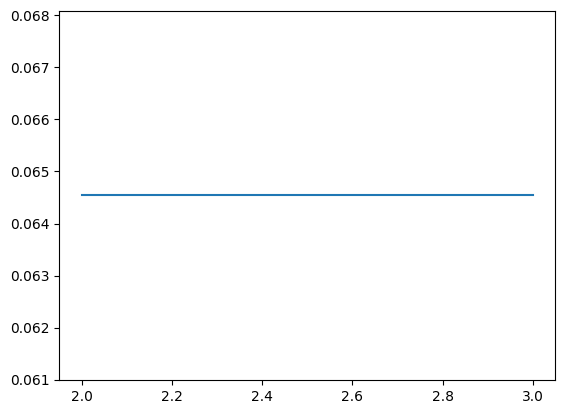

In [ ]:
p.cumulative_returns.plot()

In [ ]:
p.get_results()

{'cumulative_return': np.float64(0.06453852113757108),
 'trades':   dt  price  direction  size take_profit stop_loss
 0  1  150.0          1     1        None      None
 1  2  160.0         -1     1        None      None
 2  3  170.0          1     1        None      None
 3  2  160.0         -1     0        None      None,
 'position': 1    1
 2    0
 3    0
 dtype: int64,
 'cumulative_returns': 1         NaN
 2    0.064539
 3    0.064539
 dtype: float64}

## Real Example: BBCCI Strategy (BB & CCI bounce)

- Get data from alpaca
- Generate a trading signal
- Run a backtest
- Display Results

In [ ]:
from alpaca.data import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime


crypto_client = CryptoHistoricalDataClient()

request_params = CryptoBarsRequest(
                        symbol_or_symbols="BTC/USD",
                        timeframe=TimeFrame.Minute,
                        start=datetime(2024, 6, 2),
                        end=datetime(2024, 7, 1)
                 )

bars = crypto_client.get_crypto_bars(request_params)

# convert to dataframe
df = bars.df

In [ ]:
# cleanup
df.reset_index(inplace=True)
df.index = pd.to_datetime(df['timestamp'])
df.drop(columns=['timestamp','symbol', 'trade_count', 'vwap'], inplace=True)
df.head()

,open,high,low,close,volume
timestamp,,,,,
2024-06-02 00:06:00+00:00,67735.8775,67735.8775,67728.9950,67728.9950,0.0
2024-06-02 00:07:00+00:00,67708.9200,67708.9200,67708.9200,67708.9200,0.0
2024-06-02 00:08:00+00:00,67719.3335,67720.4800,67712.7935,67712.7935,0.0
2024-06-02 00:09:00+00:00,67726.1510,67726.8900,67710.6050,67715.3830,0.0
2024-06-02 00:10:00+00:00,67718.0300,67725.7000,67705.3215,67720.4960,0.0


In [ ]:
market_data = df['close']

In [ ]:
# BB
df['SMA'] = df['close'].rolling(window=200).mean()
df['SD'] = df['close'].rolling(window=200).std()
df['BBU'] = df.SMA + (df.SD * 2)
df['BBL'] = df.SMA + (df.SD * 2)

# CCI
df['typical_price'] = (df['high'] + df['low'] + df['close']) / 3
df['TPMA'] = df.rolling(window=200)['typical_price'].mean()
df['mean_devation'] = (df.typical_price - df.TPMA).abs().mean()
df['CCI'] = (df.typical_price - df.TPMA) / (0.015 * df.mean_devation)

df.dropna(inplace=True)

<Axes: >

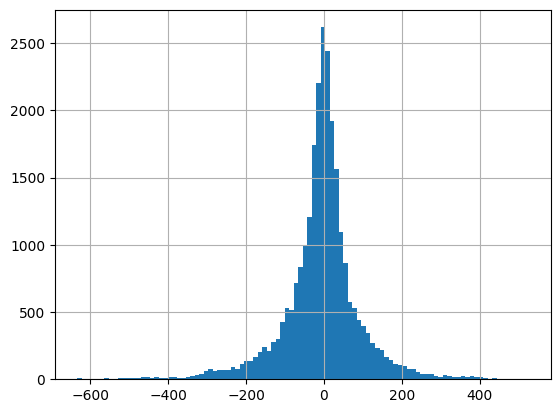

In [ ]:
df.CCI.hist(bins=100)

In [ ]:
# make signals
from pandas import Series, DataFrame
from wrtrade.strategy import Strategy

class BBCCI(Strategy):
    
    def generate_signals(self, market_data: DataFrame) -> Series:
        '''Returns a series of values in {1, 0, -1} for buy, hold, sell'''

        # generate entries
        signals = ((market_data.CCI < 200) & (market_data.close < market_data.BBL)).astype(int)

        return signals

strat = BBCCI()
signals = strat.generate_signals(df)

In [ ]:
signals.unique()

array([1, 0])

In [ ]:
from wrtrade.portfolio import Portfolio

p = Portfolio(market_data, signals)
p.calculate_portfolio_returns()
p.get_results()

INFO:wrtrade.trade:Initialized TradeEngine with max_position: 10
INFO:wrtrade.trade:Processed signals. Final position: 10
INFO:wrtrade.trade:Closed position due to take profit/stop loss at 2024-06-05 01:35:00+00:00, price: 71257.41


{'cumulative_return': np.float64(0.4548259016026286),
 'trades':                      dt       price  direction  size take_profit stop_loss
 0   2024-06-02 08:42:00  67786.2450          1     1        None      None
 1   2024-06-02 08:43:00  67760.8000          1     1        None      None
 2   2024-06-02 08:44:00  67777.1445          1     1        None      None
 3   2024-06-02 08:45:00  67773.2900          1     1        None      None
 4   2024-06-02 08:48:00  67745.8540          1     1        None      None
 5   2024-06-02 08:49:00  67754.5840          1     1        None      None
 6   2024-06-02 08:50:00  67738.4230          1     1        None      None
 7   2024-06-02 08:51:00  67715.8750          1     1        None      None
 8   2024-06-02 08:52:00  67716.1000          1     1        None      None
 9   2024-06-02 08:53:00  67720.3235          1     1        None      None
 10  2024-06-05 01:35:00  71257.4100        -10     0        None      None,
 'position': timestamp


In [ ]:
pd.options.display.max_rows = 500

In [ ]:
p.position['2024-06-05 09:00:00':'2024-06-05 10:00:00']

timestamp
2024-06-05 09:01:00+00:00    10
2024-06-05 09:02:00+00:00    10
2024-06-05 09:03:00+00:00    10
2024-06-05 09:04:00+00:00    10
2024-06-05 09:06:00+00:00    10
2024-06-05 09:09:00+00:00    10
2024-06-05 09:12:00+00:00    10
2024-06-05 09:14:00+00:00     0
2024-06-05 09:17:00+00:00     0
2024-06-05 09:19:00+00:00     0
2024-06-05 09:20:00+00:00     0
2024-06-05 09:24:00+00:00     0
2024-06-05 09:25:00+00:00     0
2024-06-05 09:28:00+00:00     0
2024-06-05 09:30:00+00:00     0
2024-06-05 09:35:00+00:00     0
2024-06-05 09:43:00+00:00     0
2024-06-05 09:44:00+00:00     0
2024-06-05 09:45:00+00:00     0
2024-06-05 09:50:00+00:00     0
2024-06-05 09:51:00+00:00     0
2024-06-05 09:58:00+00:00     0
2024-06-05 09:59:00+00:00     0
2024-06-05 10:00:00+00:00     0
dtype: int64

In [ ]:
p.trade_engine.trades

[Trade(dt='2024-06-02 08:42:00', price=np.float64(67786.245), direction=1, size=np.int64(1), take_profit=None, stop_loss=None),
 Trade(dt='2024-06-02 08:43:00', price=np.float64(67760.8), direction=1, size=np.int64(1), take_profit=None, stop_loss=None),
 Trade(dt='2024-06-02 08:44:00', price=np.float64(67777.1445), direction=1, size=np.int64(1), take_profit=None, stop_loss=None),
 Trade(dt='2024-06-02 08:45:00', price=np.float64(67773.29), direction=1, size=np.int64(1), take_profit=None, stop_loss=None),
 Trade(dt='2024-06-02 08:48:00', price=np.float64(67745.854), direction=1, size=np.int64(1), take_profit=None, stop_loss=None),
 Trade(dt='2024-06-02 08:49:00', price=np.float64(67754.584), direction=1, size=np.int64(1), take_profit=None, stop_loss=None),
 Trade(dt='2024-06-02 08:50:00', price=np.float64(67738.423), direction=1, size=np.int64(1), take_profit=None, stop_loss=None),
 Trade(dt='2024-06-02 08:51:00', price=np.float64(67715.875), direction=1, size=np.int64(1), take_profit=N

<Axes: xlabel='timestamp'>

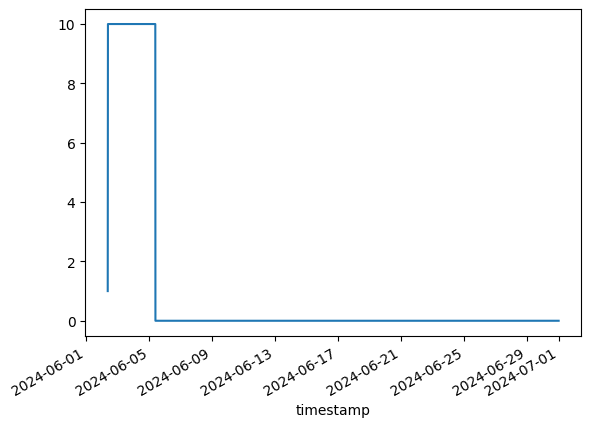

In [ ]:
p.position.plot()

<Axes: xlabel='timestamp'>

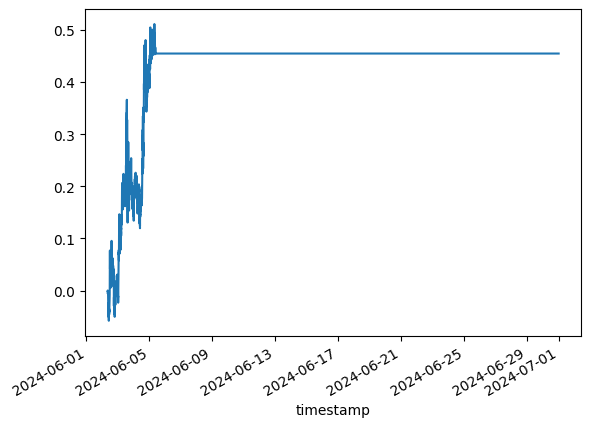

In [ ]:
p.cumulative_returns.plot()

<Axes: xlabel='timestamp'>

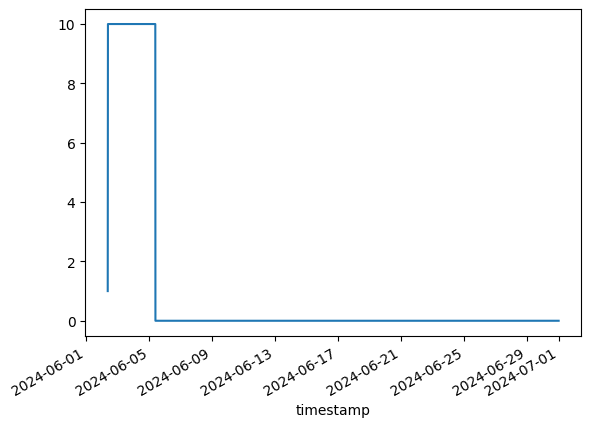

In [ ]:
p.position.plot()

<Axes: xlabel='timestamp'>

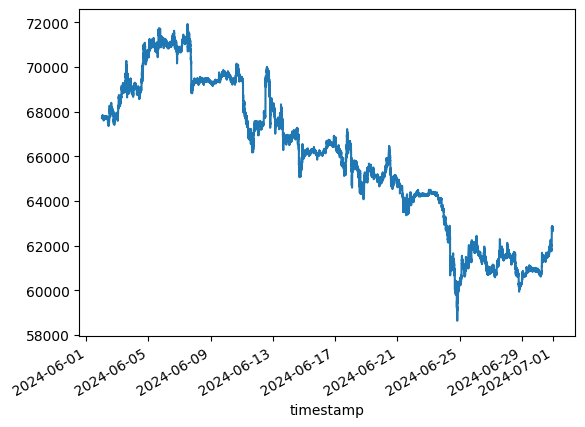

In [ ]:
p.market_data.plot()